<h1 align=center style="color:#000080;">The Secret to Reducing Health Care Costs: Predicting Health Insurance Claims with Artificial Intelligence</h1>
<h3 align=center style="color:#b30000;"> By Buhari Shehu</h3>

<img src="health_insurance.png" alt="insurance_claim_-image" style="width:1000px;height:500px;">

Photo created with [Canva](https://www.canva.com/design/DAFoOXz9KEw/t0VpGCQsoujxOrXxLYFRsw/edit?utm_content=DAFoOXz9KEw&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)

<h2 style="color:#000080;"> Table of Contents </h2>
<ul>
<li><a href="#intro">1. Introduction</a></li>
<li><a href="#wrangling">2. Data Wrangling</a></li>
<li><a href="#eda">3. Exploratory Data Analysis</a></li>
<li><a href="#model">4. Model Selection and Evaluation</a></li>
<li><a href="#conclusions">5. Conclusions</a></li>
<li><a href="#references">6. References</a></li>
</ul>

<div id='intro'></div>

<h2 style="color:#000080;"> 1. Introduction </h2>

Insurance companies collect premiums from policyholders to cover the cost of claims and make profits. The companies may need more money to cover all of the claims that are filed if they fail to predict the cost of claims accurately. This can lead to financial losses for the insurance company, and it can also lead to policyholders being underinsured. Insurance claim analysis and prediction can also help insurance companies segment policyholders based on risk level, customise marketing strategies, enhance customer satisfaction and prevent fraud.
    
The goal of this project is to explore the insurance claim dataset from Kaggle and find out what influences the cost of claims made by policyholders. We will also use regression models to forecast future claims by the policyholders. The results of this project can help the insurance company to adjust the premiums and reduce expenses. The results can also inform the government about some of the main causes of health problems.

<h3 style="color:#b30000;"> 1.1 Dataset description</h3> 

The dataset is publicly available on [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance). It consists of the following features:

- `age`: age of policyholders
- `sex`: gender of the policyholders
- `bmi`: a person’s weight in kilograms (or pounds) divided by the square of height in meters (or feet).[1](https://www.cdc.gov/healthyweight/assessing/bmi/index.html)
- `children`: number of children covered by the health insurance plan
- `smoker`: smoking status
- `region`: the policyholders' residential area in the US
- `charges`: individual medical costs billed by the health insurance company

<h3 style="color:#b30000;"> 1.2 Installing and importing dependencies</h3>    

The following packages are essential to running this project successfully: `numpy, pandas, matplotlib, seaborn, sklearn, and xgboost`.


In [1]:
# importing data analysis libraries
import numpy as np
import pandas as pd

# importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# overriding matplotlib 
sns.set()

# import a scaler
from sklearn.preprocessing import StandardScaler


# import train/test split module
from sklearn.model_selection import train_test_split

# import linear regressor
from sklearn.linear_model import LinearRegression

# import metrics
from sklearn import metrics


# import warnings
import warnings 
warnings.filterwarnings('ignore')

<h3 style="color:#b30000;"> 1.3 Loading the dataset</h3>    

In [2]:
# load the dataset
insurance_df = pd.read_csv('insurance.csv')
insurance_df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [3]:
insurance_df.tail(3)

,age,sex,bmi,children,smoker,region,charges
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


<div id='wrangling'></div>

<h2 style="color:#000080;"> 2. Data Wrangling </h2>

In this section, our primary focus will be to thoroughly examine the dataset for potential issues that could impact the accuracy and reliability of our analysis. We will carefully assess the data type discrepancies, identify any missing values, check entries duplication and flag potential outliers. Addressing these issues is crucial as they can significantly impact the validity of our conclusions.

**What is the size, data type and are there missing values in the dataset?**

In [4]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset consists of 1338 non-null entries distributed across seven features, with each feature assigned the appropriate data type.

**Are there duplicates in the dataset?**

In [5]:
# count duplicates
"The dataset comprises {} duplicate(s).".format(insurance_df.duplicated().sum())

'The dataset comprises 1 duplicate(s).'

- ***Drop the duplicate and check***

In [6]:
insurance_df = insurance_df.drop_duplicates()
"The dataset now comprises {} non-null entries.".format(insurance_df.shape[0])

'The dataset now comprises 1337 non-null entries.'

**Are there outliers in the dataset?** 

We will create a function to identify the outliers.

In [25]:
def find_outlier_rows(df, col, level='both'):
    """
  Finds the rows with outliers in a given column of a dataframe.
  
  This function takes a dataframe and a column as input, and returns the rows
  with outliers in the given column. Outliers are identified using the
  interquartile range (IQR) formula. The optional level parameter allows the
  caller to specify the level of outliers to return, i.e., lower, upper, or both.
  
  Args:
    df: The input dataframe.
    col: The name of the column to search for outliers.
    level: The level of outliers to return, i.e., 'lower', 'upper', or 'both'.
           Defaults to 'both'.
  
  Returns:
    A dataframe containing the rows with outliers in the given column.
  """
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

- ***find the outliers***

In [35]:
def count_outliers(df):
    """
    Identify and count outliers in the numeric columns of a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing numeric columns.

    Returns:
    DataFrame: A DataFrame containing the count and percentage of outliers for each numeric column.
               The index contains the column names, and the DataFrame has two columns:
               'outlier_counts': Number of outliers found in each column.
               'outlier_percent': Percentage of outliers relative to the total entries in each column.
    """
    # select numeric columns
    df_numeric = df.select_dtypes(include=['int', 'float'])
    
    # get column names
    columns = df_numeric.columns
    
    # find the name of all columns with outliers
    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]
    
    # dataframe to store the results
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])
    
    # count the outliers and compute the percentage of outliers for each column
    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count*100/all_entries, 2)

    # store the results in the dataframe
    outliers_df.loc[col] = [outlier_count, outlier_percent]
    # return the resulting dataframe
    return outliers_df

In [32]:
count_outliers(insurance_df)

,outlier_counts,outlier_percent
bmi,9.0,0.67
charges,139.0,10.40


BMI and charges have outliers. Let's examine the outliers.

In [38]:
bmi_outliers_df = find_outlier_rows(insurance_df, "bmi")
bmi_outliers_df

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


The outlier range for BMI is identified as **`47.41 - 53.13 kg/m^2`**. As these values may indicate significant health concerns, they will be retained without any modifications.

Let's see those of **`charges`**.

In [39]:
charges_outliers_df = find_outlier_rows(insurance_df, "charges")
charges_outliers_df

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


Let's see the summary statistics of `charges_outliers_df`.

In [40]:
charges_outliers_df.describe()

,age,bmi,children,charges
count,139.000000,139.000000,139.000000,139.000000
mean,41.079137,35.564604,1.187050,42103.947206
std,13.801420,4.434917,1.126546,5582.168107
min,18.000000,22.895000,0.000000,34617.840650
25%,30.000000,32.667500,0.000000,37786.149950
50%,43.000000,35.200000,1.000000,40974.164900
75%,52.500000,37.660000,2.000000,45786.706425
max,64.000000,52.580000,4.000000,63770.428010


- The outlier **`charges`** range from **`$34,617 - $63,770`**. Given that these values represent substantial costs to the insurance firm, they will be retained in the dataset without any alterations.

<div id='eda'></div>

<h2 style="color:#000080;"> 3. Exploratory Data Analysis & Feature Engineering</h2>

In this section, our aim is to thoroughly explore the dataset, uncovering patterns and insights that will serve as a guide for formulating meaningful questions and conducting in-depth analyses. To achieve this, we will also engineer new features and approach the dataset from multiple perspectives: univariate, bivariate, and multivariate.

<h3 style="color:#b30000;"> 3.2 Univariate Analyses</h3>

**What are the summary statistics of the dataset?**

In [15]:
insurance_df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Based on the above summary statistics:

1. Age and charges exhibit high variability, indicating a wide range of values within these variables.

2. More than half of the policyholders are above 39 years old, and all of them meet the necessary age requirements, with none below the legal age of 18 or having reached the retirement age of 65 years.
We will compare the charges across different age groups to gain insights into the impact of age on insurance costs.

3. Over half of the policyholders are classified as obese (BMI > 30), while a portion of them falls under the underweight category (BMI < 18.5), showcasing diverse BMI distributions. It will be interesting to compare the charges across BMI categories.

4. Approximately half of the policyholders have one or no child, indicating diverse family sizes among the insured. To further investigate the relationship between family size and insurance charges, a new feature will be engineered to categorize policyholders into different groups based on the number of children they have.

5. The highest charge observed in the dataset is $63,770, representing the most significant insurance cost incurred by a policyholder.

These insights provide a valuable overview of the dataset, highlighting the demographic and cost-related characteristics of the policyholders.

Let us investigate the skweness of the numerical variables.

**Skweness**

In [41]:
 insurance_df.skew()

age         0.054781
bmi         0.283914
children    0.937421
charges     1.515391
dtype: float64

- Based on the skewness values of less than 1 for **`age, BMI, and children`**, we can infer that these variables are approximately symmetrical. However **`charges`** with skewness greater than 1.5 are asymmetric, indicating a significant departure from symmetry. In such cases, the median may be more appropriate than the mean in summarizing the variable. 

**How are the variables distributed?**

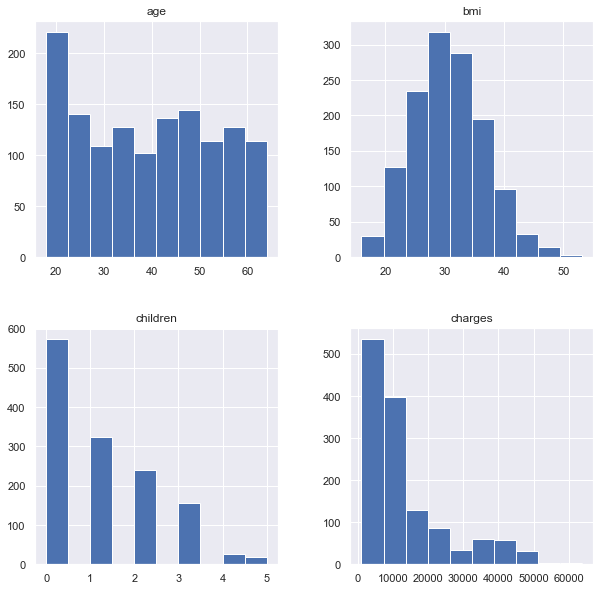

In [43]:
# histograms
list_numerical_feat = ["age", "bmi", "children", "charges"]
insurance_df[list_numerical_feat].hist(figsize=(10,10));

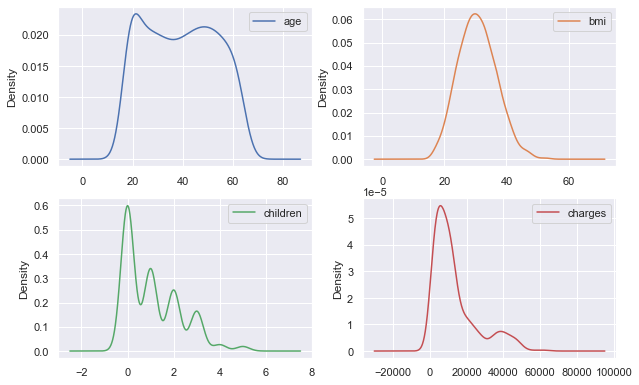

In [44]:
# density plot
insurance_df[list_numerical_feat].plot(kind='density', subplots=True, layout=(3, 2), sharex=False, figsize=(10, 10));

**How do charges differ based on BMI groups?**

To answer this question, we will group the BMI values using the following table by [CDC](https://www.cdc.gov/healthyweight/assessing/index.html):

| BMI      | Weight Status |
| ----------- | ----------- |
| Below 18.5     | Underweight|
| 18.5—24.9  | Healthy Weight |
| 25.0—29.9     | Overweight  |
| 30.0 and Above  | Obesity   |	
	
	
	

In [45]:
categories = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
thresholds = [18.5, 25, 30]

In [46]:
# Create a new column 'BMI Category' and map the values
insurance_df['bmi_category'] = pd.cut(insurance_df['bmi'], bins=[0] + thresholds + [float('inf')], labels=categories)

In [52]:
bmi_df_count = insurance_df[["bmi_category", "charges"]].groupby(by="bmi_category", as_index=False).count()
bmi_df_count 

,bmi_category,charges
0,Underweight,21
1,Normal Weight,226
2,Overweight,386
3,Obese,704


In [56]:
insurance_df["bmi_category"].value_counts()

Obese            704
Overweight       386
Normal Weight    226
Underweight       21
Name: bmi_category, dtype: int64

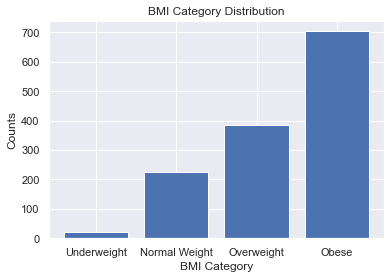

In [53]:
# Plot the bar chart
plt.bar(bmi_df_count.bmi_category, bmi_df_count.charges)
plt.xlabel('BMI Category')
plt.ylabel('Counts')
plt.title('BMI Category Distribution')

# Display the bar chart
plt.show()

The image displays a bar graph representing the distribution of BMI categories among policyholders. It reveals a significant proportion of policyholders fall into the overweight or obese categories. Specifically, the obese category comprises the largest group, followed by the overweight category, while the normal weight category ranks third in terms of prevalence. This data underscores the prevailing issue of obesity among policyholders. Conversely, the underweight category consists of the fewest individuals.

Obesity is a risk factor for many chronic diseases, such as heart disease, stroke, type 2 diabetes, and some types of cancer.
There are a number of things that can be done to reduce obesity, such as eating a healthy diet, exercising regularly, and getting enough sleep.

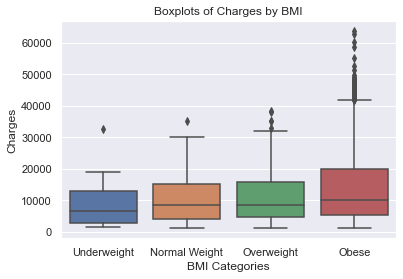

In [54]:
# Plotting multiple boxplots
sns.boxplot(x='bmi_category', y='charges', data=insurance_df)

# Adding labels and title
plt.xlabel('BMI Categories')
plt.ylabel('Charges')
plt.title('Boxplots of Charges by BMI')

# Show the plot
plt.show()

The box plot shows that the median charge is higher for people who are obese than for people who are normal weight or underweight. The interquartile range is also wider for people who are obese, which indicates that there is more variation in the charges for people who are obese. There are also a few outliers for people who are obese, which indicates that there are some people who have very high charges.

This box plot suggests that there is a positive association between BMI and charges. This means that people who are obese tend to have higher medical charges than people who are normal weight or underweight. This association may be due to a number of factors, such as the fact that obese people are more likely to have chronic diseases that require medical care.

**recommendations**

- The government could provide funding for programs that promote healthy eating and exercise.
- Employers could offer weight loss programs to their employees.
- Insurance companies could offer discounts to people who lose weight or by providing them with access to weight loss programs.
- Insurance companies could charging higher premiums for people who are obese

In [47]:
bmi_df = insurance_df[["bmi_category", "charges"]].groupby(by="bmi_category", as_index=False).sum()
bmi_df

,bmi_category,charges
0,Underweight,1.818100e+05
1,Normal Weight,2.358410e+06
2,Overweight,4.245152e+06
3,Obese,1.096881e+07


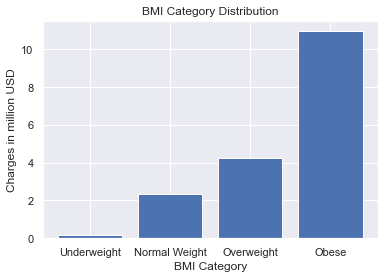

In [48]:
# Plot the bar chart
plt.bar(bmi_df.bmi_category, bmi_df.charges/1e6)
plt.xlabel('BMI Category')
plt.ylabel('Charges in million USD')
plt.title('BMI Category Distribution')

# Display the bar chart
plt.show()

### Children

In [90]:
insurance_df['child_category'] = insurance_df['children'].apply(lambda x: 'at_most_1' if x < 2 else 'more_than_1')
insurance_df['child_category'] = insurance_df['child_category'].astype('category')

In [93]:
insurance_df['sex'] = insurance_df['sex'].astype('category')
insurance_df['smoker'] = insurance_df['smoker'].astype('category')
insurance_df['region'] = insurance_df['region'].astype('category')

In [97]:
categorical_df = insurance_df.select_dtypes(include=['category'])

In [98]:
categorical_df

,sex,smoker,region,bmi_category,age_range,child_category
0,female,yes,southwest,Overweight,18-29,at_most_1
1,male,no,southeast,Obese,18-29,at_most_1
2,male,no,southeast,Obese,18-29,more_than_1
3,male,no,northwest,Normal Weight,30-39,at_most_1
4,male,no,northwest,Overweight,30-39,at_most_1
...,...,...,...,...,...,...
1333,male,no,northwest,Obese,50-59,more_than_1
1334,female,no,northeast,Obese,18-29,at_most_1
1335,female,no,southeast,Obese,18-29,at_most_1
1336,female,no,southwest,Overweight,18-29,at_most_1


In [84]:
insurance_df.drop("child_category", axis='columns', inplace=True)

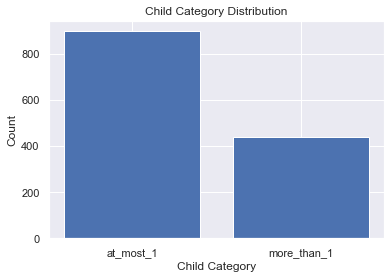

In [69]:
# Plot the bar chart
plt.bar(insurance_df["Child_Category"].value_counts().index, insurance_df["child_category"].value_counts().values)
plt.xlabel('Child Category')
plt.ylabel('Count')
plt.title('Child Category Distribution')

# Display the bar chart
plt.show()

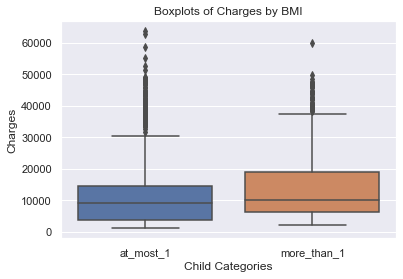

In [70]:
# Plotting multiple boxplots
sns.boxplot(x='Child_Category', y='charges', data=insurance_df)

# Adding labels and title
plt.xlabel('Child Categories')
plt.ylabel('Charges')
plt.title('Boxplots of Charges by BMI')

# Show the plot
plt.show()

In [91]:
insurance_df

,age,sex,bmi,children,smoker,region,charges,bmi_category,age_range,child_category
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight,18-29,at_most_1
1,18,male,33.770,1,no,southeast,1725.55230,Obese,18-29,at_most_1
2,28,male,33.000,3,no,southeast,4449.46200,Obese,18-29,more_than_1
3,33,male,22.705,0,no,northwest,21984.47061,Normal Weight,30-39,at_most_1
4,32,male,28.880,0,no,northwest,3866.85520,Overweight,30-39,at_most_1
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,Obese,50-59,more_than_1
1334,18,female,31.920,0,no,northeast,2205.98080,Obese,18-29,at_most_1
1335,18,female,36.850,0,no,southeast,1629.83350,Obese,18-29,at_most_1
1336,21,female,25.800,0,no,southwest,2007.94500,Overweight,18-29,at_most_1


In [76]:
# Define age ranges and corresponding labels
age_ranges = [18, 30, 40, 50, 60, 70]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69']

# Create a new column 'AgeRange' with age ranges
insurance_df['age_range'] = pd.cut(insurance_df['age'], bins=age_ranges, labels=age_labels, right=False)


In [77]:
insurance_df

,age,sex,bmi,children,smoker,region,charges,bmi_category,Child_Category,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight,at_most_1,18-29
1,18,male,33.770,1,no,southeast,1725.55230,Obese,at_most_1,18-29
2,28,male,33.000,3,no,southeast,4449.46200,Obese,more_than_1,18-29
3,33,male,22.705,0,no,northwest,21984.47061,Normal Weight,at_most_1,30-39
4,32,male,28.880,0,no,northwest,3866.85520,Overweight,at_most_1,30-39
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,Obese,more_than_1,50-59
1334,18,female,31.920,0,no,northeast,2205.98080,Obese,at_most_1,18-29
1335,18,female,36.850,0,no,southeast,1629.83350,Obese,at_most_1,18-29
1336,21,female,25.800,0,no,southwest,2007.94500,Overweight,at_most_1,18-29


In [94]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             1337 non-null   int64   
 1   sex             1337 non-null   category
 2   bmi             1337 non-null   float64 
 3   children        1337 non-null   int64   
 4   smoker          1337 non-null   category
 5   region          1337 non-null   category
 6   charges         1337 non-null   float64 
 7   bmi_category    1337 non-null   category
 8   age_range       1337 non-null   category
 9   child_category  1337 non-null   category
dtypes: category(6), float64(2), int64(2)
memory usage: 93.3 KB


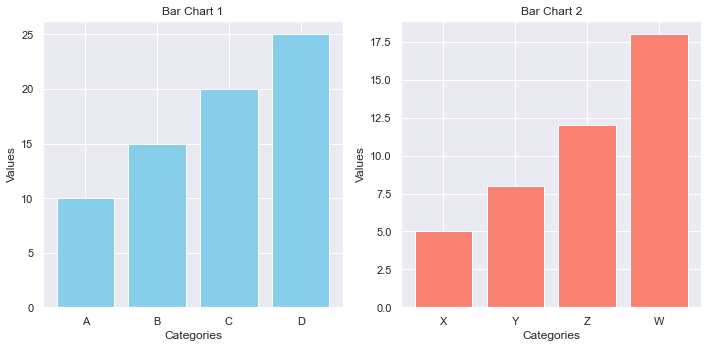

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for two bar charts
data1 = {'Category': ['A', 'B', 'C', 'D'], 'Value': [10, 15, 20, 25]}
data2 = {'Category': ['X', 'Y', 'Z', 'W'], 'Value': [5, 8, 12, 18]}

# Create DataFrame for each dataset
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot first bar chart on the first subplot
axes[0].bar(df1['Category'], df1['Value'], color='skyblue')
axes[0].set_title('Bar Chart 1')
axes[0].set_xlabel('Categories')
axes[0].set_ylabel('Values')

# Plot second bar chart on the second subplot
axes[1].bar(df2['Category'], df2['Value'], color='salmon')
axes[1].set_title('Bar Chart 2')
axes[1].set_xlabel('Categories')
axes[1].set_ylabel('Values')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


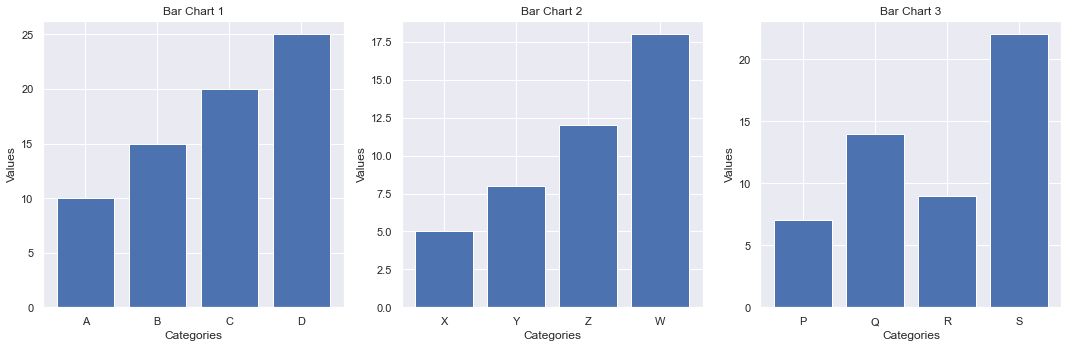

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for multiple bar charts
data = [
    {'Category': ['A', 'B', 'C', 'D'], 'Value': [10, 15, 20, 25]},
    {'Category': ['X', 'Y', 'Z', 'W'], 'Value': [5, 8, 12, 18]},
    {'Category': ['P', 'Q', 'R', 'S'], 'Value': [7, 14, 9, 22]}
]

# Create subplots dynamically based on the number of datasets
num_plots = len(data)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

# Plot each dataset as a separate bar chart
for i, dataset in enumerate(data):
    df = pd.DataFrame(dataset)
    axes[i].bar(df['Category'], df['Value'])
    axes[i].set_title(f'Bar Chart {i+1}')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Values')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


ValueError: DataFrame constructor not properly called!

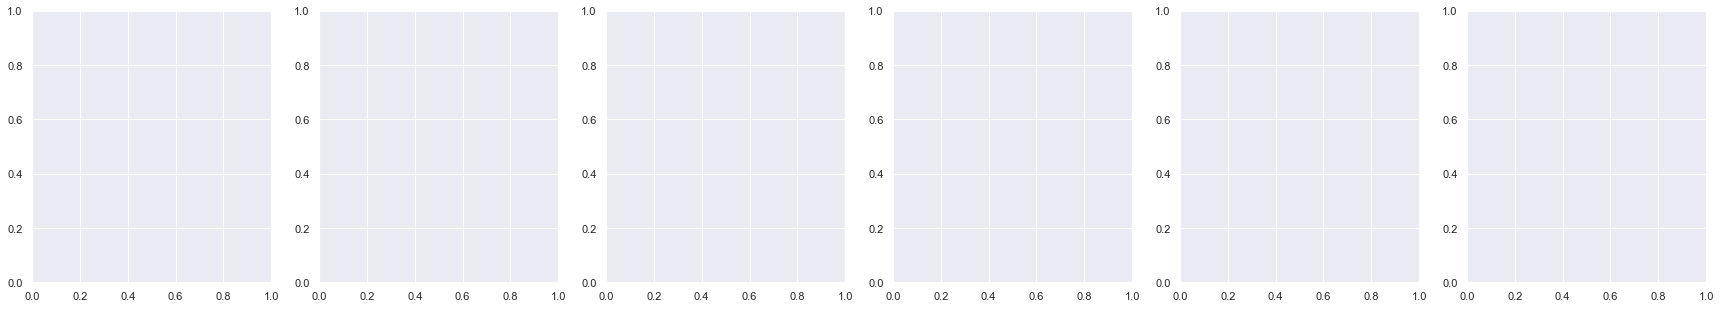

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for multiple bar charts
df = categorical_df

# Create subplots dynamically based on the number of datasets
num_plots = len(df.columns)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

# Plot each dataset as a separate bar chart
for i, col in enumerate(df.to_dict()):
    df_c = pd.DataFrame(col)
    axes[i].bar(df_c['Category'], df_c['Value'])
    axes[i].set_title(f'Bar Chart {i+1}')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Values')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [110]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_multiple_bar_charts(df):
    # Create subplots dynamically based on the number of datasets
    num_plots = len(df.columns)
    col = df.columns
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

    # Plot each dataset as a separate bar chart
    for i in range(num_plots):
        axes[i].bar(df[col[i]].value_counts().index, df[col[i]].value_counts().values)
        axes[i].set_title(f'Bar Chart {i+1}')
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Values')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()



In [124]:
def plot_multiple_bar_charts(df):
    # Create subplots dynamically based on the number of datasets
    num_plots = len(df.columns)
    col = df.columns
    
    # Determine the number of rows and columns for subplots
    num_rows = 2
    num_cols = (num_plots + 1) // 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

    # Plot each dataset as a separate bar chart
    for i in range(num_plots):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].bar(df[col[i]].value_counts().index, df[col[i]].value_counts().values)
        axes[row_idx, col_idx].set_title(f'Bar Chart {col[i]}')
        axes[row_idx, col_idx].set_xlabel('Categories')
        axes[row_idx, col_idx].set_ylabel('Values')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()


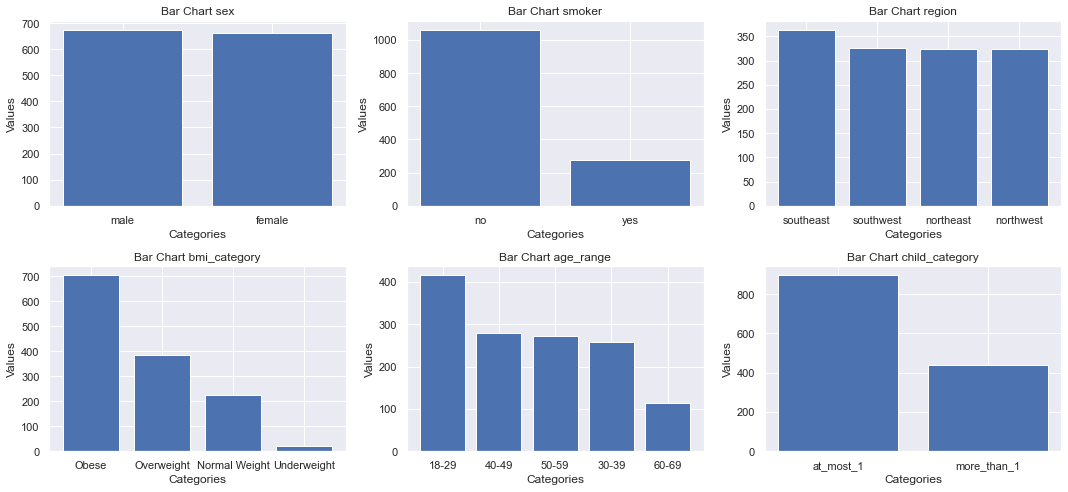

In [125]:
# Call the function with the DataFrame
plot_multiple_bar_charts(categorical_df)


In [ ]:
# box plot
sns.boxplot(x='bmi', data=df);

In [ ]:
# violin plot
sns.violinplot(x='bmi', data=df);

In [ ]:
# line plot
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(x=sales.date, y=(sales.weekly_sales/1e6))
plt.xlabel('Date')
plt.ylabel('Weekly Sales (in million USD)')
plt.title('Weekly Sales Trend',fontdict={'fontsize': 16, 'color':'red'}, pad=5)
plt.show()

In [ ]:
# tool tip
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12,6))
# plot and labels
sc = ax.scatter(x,y)
plt.xlabel(x_name)
plt.ylabel(y_name)
# cursor grid lines
lnx = plt.plot([60,60], [0,1.5], color='black', linewidth=0.3)
lny = plt.plot([0,100], [1.5,1.5], color='black', linewidth=0.3)
lnx[0].set_linestyle('None')
lny[0].set_linestyle('None')
# annotation
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points")
annot.set_visible(False)
# xy limits
plt.xlim(x.min()*0.95, x.max()*1.05)
plt.ylim(y.min()*0.95, y.max()*1.05)
def hover(event):
    # check if event was in the axis
    if event.inaxes == ax:
        # draw lines and make sure they're visible
        lnx[0].set_data([event.xdata, event.xdata], [0, 1.5])
        lnx[0].set_linestyle('--')
        lny[0].set_data([0,100], [event.ydata, event.ydata])
        lny[0].set_linestyle('--')
        lnx[0].set_visible(True)
        lny[0].set_visible(True)
        
        # get the points contained in the event
        cont, ind = sc.contains(event)
        if cont:
            # change annotation position
            annot.xy = (event.xdata, event.ydata)
            # write the name of every point contained in the event
            annot.set_text("{}".format(', '.join([tt[n] for n in ind["ind"]])))
            annot.set_visible(True)    
        else:
            annot.set_visible(False)
    else:
        lnx[0].set_visible(False)
        lny[0].set_visible(False)
fig.canvas.mpl_connect("motion_notify_event", hover)
plt.show()

**Multivariate**

In [ ]:
df.corr()

In [ ]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
# clustered bar chart


In [ ]:
# scatter plot
sns.scatterplot(x='age',y='bmi',hue='insurance_claim', data=df);

In [ ]:
# pair plot

sns.set_style("whitegrid");
sns.pairplot(df, hue="insurance_claim");
plt.show();

In [ ]:
# bubble plot
plt.figure(figsize=(12,8))
sns.scatterplot(x="bmi",
                y="claim_amount",
                size="children",
                sizes=(20,100),
                alpha=0.8,
                hue="smoker",
                data=df);

In [ ]:
# joint plot
sns.jointplot(x = 'age', y = 'bmi', data = df);
 
sns.jointplot(x = 'age', y = 'bmi', data = df, hue='insurance_claim');

In [ ]:
# line plot
plt.plot(np.arange(len(df.Y)), df.Y)
plt.title("ZAR/USD over time")
plt.xlabel("Months")
plt.ylabel("ZAR/USD")
plt.show()

In [ ]:
# 2 in 1 line plot
from matplotlib import rc
rc('mathtext', default='regular')
# Create blank figure
fig = plt.figure()


# Split figure to allow two sets of y axes
ax = fig.add_subplot(111)


# Plot the first line on its axis
ax.plot(np.arange(len(df.Y)), df.Y, '-', label = 'ZAR/USD', color='orange')


# Create second y axis and plot second line
ax2 = ax.twinx()
ax2.plot(np.arange(len(df.X)), df.X, '-', label = 'Exports (ZAR)')


# Add legends for each axis
ax.legend(loc=2)
ax2.legend(loc=9)


ax.grid()


# Set labels of axes
ax.set_xlabel("Months")
ax.set_ylabel("ZAR/USD")
ax2.set_ylabel("Exports (ZAR, millions)")
plt.show()


**Issues**

***Predictors issues***
- `linearity`: when we see that the Xs are not linear from the scatter plots of Xs and y we may need to transform the Xs and/or y with functions like log(x) and check to see if there is linearity then apply a linear function.
- `collinearity`/- `multicollinearity`: when Xs are correlated with one another. This makes it hard to determine the effect of Xs on y. Similar to collinearity. This can be checked with varience inflation factor (VIF). **0-5 good, 6-10: pay attention can remove and leave one of those, >10 remove**

If we fit a regression model to a dataset that is non-linear, it will fail to adequately capture the relationship in the data - resulting in a mathematically inappropriate model. In order to check for linearity, we can produce scatter plots of each individual predictor against the response variable. The intuition here is that we are looking for obvious linear relationships.

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(df.columns):
    axs[index-1].set_title("{} vs. mpg".format(column),fontsize=16)
    axs[index-1].scatter(x=df[column],y=df['mpg'],color='blue',edgecolor='k')

fig.tight_layout(pad=1)


Checking for Multicollinearity
Multicollinearity refers to the presence of strong correlation among two or more of the predictor variables in the dataset. The presence of any correlation among predictors is detrimental to model quality for two reasons:

It tends to increase the standard error;

It becomes difficult to estimate the effect of any one predictor variable on the response variable.

We will check for multicollinearity by generating pairwise scatter plots among predictors, and further, generating a correlation heatmap.

In [ ]:
# Due to the number of visuals created, this codeblock takes about one minute to run.
from seaborn import pairplot
g = pairplot(df1.drop('mpg', axis='columns'))
g.fig.set_size_inches(9,9)


***residuals issues***
- `independence/ autocorrelation` when there is correlation between **residuals**. This is not desirable. It is abd especially for time series models. This can be checked by plotting the residuals and check for rectangular patterns. Can also be checked using Durbin-Watson stat: desired value approx 2, 0-2 positive autocorrelation, 2-4 negative autocorrelation
- `homoscadacity`: constant varience among residuals for all fitted values. this makes it difficult to guage the standard deviation or error of the forecast prediction., narrow confidence interval. This can be checked by plotting residuals against predicted y. We seek a recatangular pattern not funnel one.
- `normality`: errors/residuals are generated from normal distribution: may not be necessary, check with quantile-quantile plot, shapiro will

<div id='model'></div>

## 4. Model Selection and Evaluation

In [ ]:
df1 = df.copy()

In [ ]:
# get the predictor and the predicted variables
X = _df.drop(['col'], axis=1)
y = _df['col']

In [ ]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [ ]:
# instantiatiating the model
lm = LinearRegression()

In [ ]:
# fitting the model
lm.fit(X_train, y_train)

#without splitting
X = df.X[:,np.newaxis] # convert shape of X from (n,) to (n,1)
lm.fit(X, y)

**Evaluating the model on train set: how well the line fits the data**

In [ ]:
# prediction
# generate values of y from x, using the linear model
y_pred = lm.predict(X_train)

In [ ]:
print('MSE:', metrics.mean_squared_error(y_train, y_pred))

In [ ]:
# Multiple MSE by N to get RSS
print("Residual sum of squares:", metrics.mean_squared_error(y_train, y_pred)*len(X))

In [ ]:
print('R_squared:', metrics.r2_score(y_train, y_pred))

In [ ]:
print("Training:")
# Calculate the mean-squared-error
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
# Calculate the R-squared metric
print('R_squared:', metrics.r2_score(y_train, y_pred))

In [ ]:
# for slr
# plot the results
plt.scatter(X, y)  # plot the original data
plt.plot(X, gen_y, color='red')  # plot the line connecting the generated y-values
plt.ylabel("ZAR/USD")
plt.xlabel("Value of Exports (ZAR, millions)")
plt.show()

**Testing the model on test set**

In [ ]:
y_pred = lm.predict(X_test)

In [ ]:
print("Testing:")
print('MSE:', metrics.mean_squared_error(y_test, gen_y_test))
print('R_squared:', metrics.r2_score(y_test, gen_y_test))

In [ ]:
# evaluating MLR
from sklearn import metrics
import math

# dictionary of results
results_dict = {'Training MSE':
                    {
                        "SLR": metrics.mean_squared_error(y_train, slr.predict(X_train[['disp']])),
                        "MLR": metrics.mean_squared_error(y_train, lm.predict(X_train))
                    },
                'Test MSE':
                    {
                        "SLR": metrics.mean_squared_error(y_test, slr.predict(X_test[['disp']])),
                        "MLR": metrics.mean_squared_error(y_test, lm.predict(X_test))
                    },
                'Test RMSE':
                    {
                        "SLR": math.sqrt(metrics.mean_squared_error(y_test, slr.predict(X_test[['disp']]))),
                        "MLR": math.sqrt(metrics.mean_squared_error(y_test, lm.predict(X_test)))
                    }
                }

**Note**
If Mean squared error is higher on the test set than the train set, indicating poor predictive accuracy, and R-squared is lower on the test set, indicating a worse fit on the test set.

These results indicate a concept in machine learning model fitting known as overfitting. This is a phenomenon where there is:

A discrepancy between the performance of the model on train and on test sets; and
An inability of the model to generalise to data it has not seen before.
The term comes from the fact that the model fits too well, or overfits, the training data, and does not fit well, or underfits, the testing data.

In the trains to follow, we'll look at ways to improve model performance as well as prevent or mitigate overfitting.

**Note**

For big dataset we can have 3 splits: train, validation and test splits. The validation is used to check improvement in hyperparameter tuning. After we are satisfied with that we then use the test set.

For small dataset where we can't afford 3 splits we can use cross-validation like k-fold. This can be used to prevent overfitting.

**Stat model**

SK Learn is limited in terms of metrics

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
# generating string for regression

formula_str = df1.columns[0]+' ~ '+'+'.join(df1.columns[1:]); formula_str

# the model 
model=sm.ols(formula=formula_str, data=df1)
fitted = model.fit()
# print model stats
print(fitted.summary())

<div id='conclusions'></div>

## 5. Conclusions

<div id='references'></div>

## 6. References

- [Body Mass Index (BMI)](https://www.cdc.gov/healthyweight/assessing/bmi/index.html)